# Script to further explore and refine C-CLAMP's network analyses
This script has to be available within the same folder as `CCLAMP_Directed_Network_update.txt`

In [8]:
# Import the necessary packages
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
import leidenalg
from pyvis.network import Network
import igraph as ig
import seaborn as sns

## Step 1: Construct the network

In [10]:
# Read the network
network = pd.read_csv("CCLAMP_Directed_Network_update.txt", sep="\t", encoding='utf-8')
network.head(10)

,Target,Source,Weight,Target_DOB,Source_DOB
0,Hendrik Andriessen,Albert Helman,3,1892-09-17,1903-11-07
1,Henri Bruning,Henk Kuitenbrouwer,12,1900-07-10,1903-11-20
2,Henri Bruning,Jan Bruna,3,1900-07-10,1876-08-17
3,Joep Nicolas,Henk Kuitenbrouwer,3,1897-10-06,1903-11-20
4,Joep Nicolas,Jan Bruna,2,1897-10-06,1876-08-17
5,Albert Kuyle,Henk Kuitenbrouwer,37,1904-02-17,1903-11-20
6,Albert Kuyle,Jan Bruna,3,1904-02-17,1876-08-17
7,Albe,Henk Kuitenbrouwer,25,1902-06-08,1903-11-20
8,Albe,Jan Bruna,2,1902-06-08,1876-08-17
9,Carel Scharten,Jan Engelman,2,1878-03-14,1900-06-07


In [11]:
# Create a weighted graph
G = nx.from_pandas_edgelist(network, 
                            source = 'Source', 
                            target = 'Target', 
                            edge_attr = 'Weight',
                            create_using = nx.DiGraph())
print(G)

DiGraph with 7451 nodes and 156123 edges


In [12]:
# Convert directed graph to undirected
G_undirected = G.to_undirected()

## Step 2: Add measures and metadata

In [14]:
## Add centrality measures to graph
# Degree Centrality
degree_dict = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_dict, 'degree')

# In-Degree Centrality
in_degree_dict = nx.in_degree_centrality(G)
nx.set_node_attributes(G, in_degree_dict, 'in_degree')

# Out-Degree Centrality
out_degree_dict = nx.out_degree_centrality(G)
nx.set_node_attributes(G, out_degree_dict, 'out_degree')

# Betweenness Centrality
betweenness_dict = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

# Closeness Centrality
closeness_dict = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness_dict, 'closeness')

# Harmonic Centrality
harmonic_dict = nx.harmonic_centrality(G)
nx.set_node_attributes(G, harmonic_dict, 'harmonic')

# Eigenvector Centrality
eigenvector_dict = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [15]:
# Set the degree as attribute to determine the node size
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'node_degree')

In [16]:
print(max(node_degree.values()))
print(min(node_degree.values()))

2242
1


In [17]:
## Compute clustering coefficients
# Transitivity
print(nx.transitivity(G))

# Clustering coefficient for nodes
clustering_dict = nx.clustering(G)
nx.set_node_attributes(G, clustering_dict, 'clustering')

# Average clustering coefficient
print(nx.average_clustering(G))

# Square clustering
square_clustering_dict = nx.square_clustering(G)
nx.set_node_attributes(G, square_clustering_dict, 'square_clustering')

0.07830132618913196
0.26679964080892854


In [18]:
# Creating DataFrames from the centrality dictionaries
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])
in_degree_df = pd.DataFrame.from_dict(in_degree_dict, orient='index', columns=['In-degree'])
out_degree_df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['Out-degree'])
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['Betweenness'])
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['Closeness'])
harmonic_df = pd.DataFrame.from_dict(harmonic_dict, orient='index', columns=['Harmonic'])
eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient='index', columns=['Eigenvector'])
clustering_df = pd.DataFrame.from_dict(clustering_dict, orient='index', columns=['Clustering'])
square_clustering_df = pd.DataFrame.from_dict(square_clustering_dict, orient='index', columns=['Square_Clustering'])

# Merging all DataFrames on the "Author" index
centrality_clustering_df = degree_df.join(in_degree_df).join(out_degree_df).join(betweenness_df).join(closeness_df).join(harmonic_df).join(eigenvector_df).join(clustering_df).join(square_clustering_df)

# Rename the index to "Author"
centrality_clustering_df.index.name = 'Author'

# Display the first 10 rows of the merged DataFrame
print(centrality_clustering_df.head(10))

# Save the merged DataFrame to a txt file
centrality_clustering_df.to_csv("network_centralities and clustering.txt", index=True, sep='\t', encoding='utf-8')

                      Degree  In-degree  Out-degree  Betweenness  Closeness  \
Author                                                                        
Albert Helman       0.039463   0.026846    0.012617     0.002881   0.299534   
Hendrik Andriessen  0.008859   0.006980    0.001879     0.000430   0.258044   
Henk Kuitenbrouwer  0.030604   0.005906    0.024698     0.001119   0.259426   
Henri Bruning       0.013020   0.013020    0.000000     0.000000   0.288607   
Jan Bruna           0.008188   0.001879    0.006309     0.000130   0.245348   
Joep Nicolas        0.009530   0.008054    0.001477     0.000662   0.259083   
Albert Kuyle        0.038523   0.019597    0.018926     0.001454   0.285364   
Albe                0.300940   0.297718    0.003221     0.065207   0.450709   
Jan Engelman        0.064295   0.031141    0.033154     0.009215   0.310071   
Carel Scharten      0.038255   0.014228    0.024027     0.003389   0.296323   

                       Harmonic  Eigenvector  Clust

## Step 3: Apply the Louvain algorithm

In [20]:
## Partition into communities
# Create communities
communities = community_louvain.best_partition(G_undirected)

# Print communities
print(communities)

{'Albert Helman': 0, 'Hendrik Andriessen': 1, 'Henk Kuitenbrouwer': 0, 'Henri Bruning': 0, 'Jan Bruna': 0, 'Joep Nicolas': 0, 'Albert Kuyle': 0, 'Albe': 2, 'Jan Engelman': 0, 'Carel Scharten': 2, 'Willem Maas': 0, 'Frans Coenen': 3, 'Herman Robbers': 2, 'Roel Houwink': 3, 'Dirk Coster': 0, 'F. Bordewijk': 3, 'Albert Plasschaert': 0, 'Erich Wichman': 0, 'L.J.M. Feber': 0, 'Willem Pijper': 3, 'Frederik van Eeden': 3, 'M. Bruna': 0, 'Karel van den Oever': 0, 'Just Havelaar': 3, 'Gerard Bruning': 0, 'Gerard Brom': 2, 'Frans Erens': 0, 'H. Marsman': 3, 'Herman Menagé Challa': 0, 'C.J. Kelk': 3, 'H.W.J.M. Keuls': 3, 'P.C. Boutens': 3, 'Bernard Verhoeven': 0, 'Multatuli': 2, 'Albert Verwey': 3, 'Marcellus Emants': 2, 'Hélène Swarth': 2, 'Herman Gorter': 4, 'Wouter Hutschenruyter': 2, 'J.A. Lambert-van der Kolf': 3, 'Marie Koenen': 0, 'Marie Gijsen': 0, 'Ed. Hoornik': 1, 'Rie Cramer': 0, 'Johan de Meester': 2, 'Pieter van der Meer de Walcheren': 0, 'Pol de Mont': 0, 'Karel van de Woestijne': 0

In [21]:
# Save the communities
communities_df = pd.DataFrame.from_dict(communities, orient='index')
communities_df = communities_df.rename_axis('Author').reset_index()
communities_df.columns = ['Author', 'Community']
print(communities_df.head(10))
communities_df.to_csv("network_louvain_communities.txt", index=True, sep='\t', encoding='utf-8')

               Author  Community
0       Albert Helman          0
1  Hendrik Andriessen          1
2  Henk Kuitenbrouwer          0
3       Henri Bruning          0
4           Jan Bruna          0
5        Joep Nicolas          0
6        Albert Kuyle          0
7                Albe          2
8        Jan Engelman          0
9      Carel Scharten          2


In [22]:
## Explore Louvain communities
# Total number of communities
num_communities = len(set(communities.values()))
print(num_communities)

# Community sizes
community_sizes = {}
for node, community in communities.items():
    if community in community_sizes:
        community_sizes[community] += 1
    else:
        community_sizes[community] = 1
print("Community sizes:", community_sizes)

print(max(community_sizes.values()))
print(min(community_sizes.values()))
print(np.mean(list(community_sizes.values())))

45
Community sizes: {0: 1147, 1: 1600, 2: 1662, 3: 1236, 4: 1627, 17: 13, 15: 2, 18: 2, 23: 2, 27: 17, 37: 12, 38: 4, 41: 2, 42: 2, 19: 2, 20: 2, 21: 2, 22: 8, 24: 2, 25: 2, 26: 2, 28: 2, 29: 3, 30: 2, 31: 2, 32: 30, 33: 2, 34: 4, 35: 2, 36: 2, 39: 2, 40: 2, 43: 2, 44: 2, 5: 25, 6: 3, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 16: 2}
1662
2
165.57777777777778


In [23]:
## Split the network into its subgraphs based on the Louvain communities
louvain_subgraphs = {}
for community_id in set(communities.values()):
    # Find the nodes that belong to the community
    community_nodes = [node for node, comm in communities.items() if comm == community_id]
    
    # Create a subgraph
    louvain_subgraph = G_undirected.subgraph(community_nodes)
    
    # Store the subgraph
    louvain_subgraphs[community_id] = louvain_subgraph

In [24]:
# Calculate measures per subgraph
louvain_subgraphs_metrics = []

for community_id, louvain_subgraph in louvain_subgraphs.items():
    transitivity = nx.transitivity(louvain_subgraph)
    average_clustering = nx.average_clustering(louvain_subgraph)
    community_size = len(louvain_subgraph)

    louvain_subgraphs_metrics.append({
        'community': community_id,
        'transitivity': transitivity,
        'average_clustering': average_clustering,
        'community_size': community_size
    })

louvain_subgraphs_metrics_df = pd.DataFrame(louvain_subgraphs_metrics)
print(louvain_subgraphs_metrics_df.head())
louvain_subgraphs_metrics_df.to_csv("network_louvain_subgraphs_metrics.txt", index=True, sep='\t', encoding='utf-8')

   community  transitivity  average_clustering  community_size
0          0      0.282916            0.525578            1147
1          1      0.172813            0.334170            1600
2          2      0.101506            0.253941            1662
3          3      0.180781            0.398144            1236
4          4      0.194807            0.534619            1627


In [25]:
# Set the Louvain communities as node attributes
nx.set_node_attributes(G, communities, 'louvain_communities')

## Step 4: Apply the Leiden algorithm

In [27]:
# Convert to an iGraph (see: https://github.com/vtraag/leidenalg/issues/65)
g = ig.Graph.from_networkx(G_undirected)
nodes_list = np.asarray(g.vs["_nx_name"])

# Create communities
leiden_communities = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

partitions = dict()
for partition, nodes in enumerate(leiden_communities):
    mapping = dict(zip(nodes_list[nodes], [partition]*len(nodes)))
    partitions.update(mapping)

print(partitions)

{'Ed. Hoornik': 0, 'Nico Rost': 0, 'A. Roland Holst': 0, 'Gérard de Nerval': 0, 'Sigmund Freud': 0, 'William Blake': 0, 'Joris Iven': 0, 'Joris Ivens': 0, 'Herluf van Merlet': 0, 'Herman Heijermans': 0, 'Insider': 0, 'Louis Saalborn': 0, 'J.C. Noordstar': 0, 'Giacomo Leopardi': 0, 'Han G. Hoekstra': 0, 'D.H. Lawrence': 0, 'Ben Onie': 0, 'H.M. van Randwijk': 0, 'Anton Koolhaas': 0, 'Bertus van Lier': 0, 'Stéphane Mallarmé': 0, 'Maurits Mok': 0, 'Bertus Aafjes': 0, 'Bert Bakker': 0, 'Victor J. Brunclair': 0, 'Thomas Mann': 0, 'Dick Elffers': 0, 'Hans Keilson': 0, 'Frans Kusters': 0, 'Victor E. van Vriesland': 0, 'Pierre H. Dubois': 0, 'Max Nord': 0, 'Gerrit Achterberg': 0, 'James Joyce': 0, 'H.J.M.F. Lodewick': 0, 'J. van Delden': 0, 'William Butler Yeats': 0, 'L.M. Heemskerk': 0, 'David Koning': 0, 'Jan Wit': 0, 'Edgar Allan Poe': 0, 'A. Viruly': 0, 'H. van Lennep': 0, 'H. de Lange': 0, 'Francis Bacon': 0, 'W. Burger': 0, 'J. Pen': 0, 'Daniël de Lange': 0, 'Jan Noordzij': 0, 'J. Bruyn':

In [28]:
# Save the partitions
partitions_df = pd.DataFrame.from_dict(partitions, orient='index')
partitions_df = partitions_df.rename_axis('Author').reset_index()
partitions_df.columns = ['Author', 'Partition']
print(partitions_df.head(10))
partitions_df.to_csv("network_leiden_partitions.txt", index=True, sep='\t', encoding='utf-8')

              Author  Partition
0        Ed. Hoornik          0
1          Nico Rost          0
2    A. Roland Holst          0
3   Gérard de Nerval          0
4      Sigmund Freud          0
5      William Blake          0
6         Joris Iven          0
7        Joris Ivens          0
8  Herluf van Merlet          0
9  Herman Heijermans          0


In [29]:
## Explore Leiden partitions
# Total number of partitions
num_partitions = len(set(partitions.values()))
print(num_partitions)

# Partition sizes
partition_sizes = {}
for node, partition in partitions.items():
    if partition in partition_sizes:
        partition_sizes[partition] += 1
    else:
        partition_sizes[partition] = 1
print("Partition sizes:", partition_sizes)

print(max(partition_sizes.values()))
print(min(partition_sizes.values()))
print(np.mean(list(partition_sizes.values())))

41
Partition sizes: {0: 1689, 1: 1568, 2: 1534, 3: 1454, 4: 1043, 5: 30, 6: 27, 7: 19, 8: 12, 9: 8, 10: 4, 11: 3, 12: 3, 13: 3, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2}
1689
2
181.73170731707316


In [30]:
## Split the network into its subgraphs based on the Leiden partitions
leiden_subgraphs = {}
for partition_id in set(partitions.values()):
    # Find the nodes that belong to this partition
    partition_nodes = [node for node, part in partitions.items() if part == partition_id]
    
    # Create a subgraph for this partition
    leiden_subgraph = G_undirected.subgraph(partition_nodes)
    
    # Store the subgraph in the dictionary
    leiden_subgraphs[partition_id] = leiden_subgraph

In [31]:
# Calculate measures per subgraph
leiden_subgraphs_metrics = []

for partition_id, leiden_subgraph in leiden_subgraphs.items():
    transitivity = nx.transitivity(leiden_subgraph)
    average_clustering = nx.average_clustering(leiden_subgraph)
    partition_size = len(leiden_subgraph)

    leiden_subgraphs_metrics.append({
        'community': partition_id,
        'transitivity': transitivity,
        'average_clustering': average_clustering,
        'community_size': partition_size
    })

leiden_subgraphs_metrics_df = pd.DataFrame(leiden_subgraphs_metrics)
print(leiden_subgraphs_metrics_df.head())
leiden_subgraphs_metrics_df.to_csv("network_leiden_subgraphs_metrics.txt", index=True, sep='\t', encoding='utf-8')

   community  transitivity  average_clustering  community_size
0          0      0.170814            0.326346            1689
1          1      0.197113            0.528877            1568
2          2      0.173250            0.389565            1534
3          3      0.100462            0.242979            1454
4          4      0.296657            0.531558            1043


In [32]:
# Set the partitions as node attributes
nx.set_node_attributes(G, partitions, 'leiden_partitions')

## Step 5: Save the network and join all data frames

In [34]:
# Save the network
nx.write_graphml(G, "CCLAMP_Network.graphml")

In [35]:
# Read metadata
metadata_df = pd.read_csv("author_metadata_hisclass_final.txt", sep="\t", encoding='utf-8')
metadata_df = metadata_df.drop_duplicates(subset='Author', keep=False)
metadata_df.head()

,Author,Link,identifier,givenName,familyName,alternateNames,birthDate,birthPlace,birthCountry,deathDate,...,deathCountry,gender,occupation,period,language,category,organisation,occupationHisclass,Hisclass,lowestHisclass
0,Jan Engelman,https://www.dbnl.org/auteurs/auteur.php?id=eng...,enge016,Johannes Aloysius Antonius,Engelman,Jan Engelman,1900-06-07,Utrecht,Nederland,1972-03-20,...,Nederland,male,redacteur/journalist/vertaler,Twintigste Eeuw,nl,secundair/nonfictie,NaN,redacteur/vertaler/journalist,2.0/4.0/2.0,2.0
1,Willem Maas,https://www.dbnl.org/auteurs/auteur.php?id=maa...,maas024,Willem Arnoldus,Maas,Willem Maas,1897-04-28,Utrecht,Nederland,1950-05-06,...,Nederland,male,illustrator/tekenaar/beeldend kunstenaar,Twintigste Eeuw,NaN,NaN,NaN,tekenaar/illustrateur/beeldhouwer,4.0/4.0/4.0,4.0
2,Joep Nicolas,https://www.dbnl.org/auteurs/auteur.php?id=nic...,nico008,Josephus Antonius Hubertus Franciscus,Nicolas,Joep Nicolas,1897-10-06,Roermond,Nederland,1972-07-25,...,Nederland,male,schilder/ambachtsman,Twintigste Eeuw,NaN,nonfictie,NaN,ambachtsman/schilder,7.0/9.0,7.0
3,Albert Helman,https://www.dbnl.org/auteurs/auteur.php?id=hel...,helm003,Albert,Helman,Albert Helman/Beckmesser/Brandaris/Floris Kapt...,1903-11-07,Paramaribo,Suriname,1996-07-10,...,Nederland,male,musicus/journalist/politicus/redacteur/staatsm...,Twintigste Eeuw,nl,jeugdliteratuur/nonfictie/suriname/buitenland,NaN,bestuurder/redacteur/speelman/ambtman/journali...,1.0/2.0/4.0/1.0/2.0/7.0/4.0,1.0
4,Willem Nieuwenhuis,https://www.dbnl.org/auteurs/auteur.php?id=nie...,nieu047,Willem,Nieuwenhuis,Willem Nieuwenhuis,1886-xx-xx,NaN,NaN,1935-xx-xx,...,NaN,male,NaN,Twintigste Eeuw,nl,NaN,NaN,NaN,NaN,NaN


In [36]:
# Merge all files
network_metadata_df = pd.merge(centrality_clustering_df, communities_df, on='Author', how='left')
network_metadata_df = pd.merge(network_metadata_df, partitions_df, on='Author', how='left')
network_metadata_df = pd.merge(network_metadata_df, metadata_df, on='Author', how='left')
network_metadata_df

,Author,Degree,In-degree,Out-degree,Betweenness,Closeness,Harmonic,Eigenvector,Clustering,Square_Clustering,...,deathCountry,gender,occupation,period,language,category,organisation,occupationHisclass,Hisclass,lowestHisclass
0,Albert Helman,0.039463,0.026846,0.012617,0.002881,0.299534,2470.352381,0.048286,0.091079,0.039239,...,Nederland,male,musicus/journalist/politicus/redacteur/staatsm...,Twintigste Eeuw,nl,jeugdliteratuur/nonfictie/suriname/buitenland,NaN,bestuurder/redacteur/speelman/ambtman/journali...,1.0/2.0/4.0/1.0/2.0/7.0/4.0,1.0
1,Hendrik Andriessen,0.008859,0.006980,0.001879,0.000430,0.258044,2093.235714,0.011405,0.201123,0.062658,...,Nederland,male,jongleur/musicus/minstreel,Twintigste Eeuw,nl,NaN,NaN,speelman/acrobaat/musicus,4.0/7.0/4.0,4.0
2,Henk Kuitenbrouwer,0.030604,0.005906,0.024698,0.001119,0.259426,2098.583333,0.015755,0.112881,0.039154,...,Nederland,male,onderwijzer (basisschool)/redacteur/journalist,Twintigste Eeuw,NaN,jeugdliteratuur,NaN,onderwijzer op een lagere school/redacteur/jou...,4.0/2.0/2.0,2.0
3,Henri Bruning,0.013020,0.013020,0.000000,0.000000,0.288607,2351.026190,0.030483,0.155391,0.000000,...,Nederland,male,NaN,Twintigste Eeuw,nl,NaN,NaN,NaN,NaN,NaN
4,Jan Bruna,0.008188,0.001879,0.006309,0.000130,0.245348,1954.161905,0.007261,0.281233,0.061986,...,NaN,male,redacteur/journalist,Twintigste Eeuw,nl,secundair,NaN,redacteur/journalist,2.0/2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7446,T. Noordenbos-de Klerk,0.000268,0.000134,0.000134,0.000000,0.207367,1633.409127,0.000353,0.000000,0.000000,...,NaN,female,vertaler,Twintigste Eeuw,NaN,nonfictie,NaN,vertaler,4.0,4.0
7447,Jacob Léon Wertheim,0.000537,0.000268,0.000268,0.000000,0.221930,1746.966667,0.000802,1.000000,0.119497,...,Nederland,male,NaN,Negentiende Eeuw,nl,NaN,NaN,NaN,NaN,NaN
7448,Jac Heeren,0.000268,0.000134,0.000134,0.000000,0.222525,1747.323810,0.000768,0.000000,0.000000,...,NaN,male,archeoloog/historicus,Twintigste Eeuw,nl,secundair,NaN,antropoloog/oudheidkundige,2.0/2.0,2.0
7449,Isaac van der Velde,0.000268,0.000134,0.000134,0.000000,0.175699,1352.762698,0.000016,0.000000,0.000000,...,NaN,male,NaN,Twintigste Eeuw,NaN,taalkunde,NaN,NaN,NaN,NaN


In [37]:
# Save
network_metadata_df.to_csv("network_metadata.txt", index=True, sep='\t', encoding='utf-8')

## Visualise centrality measures

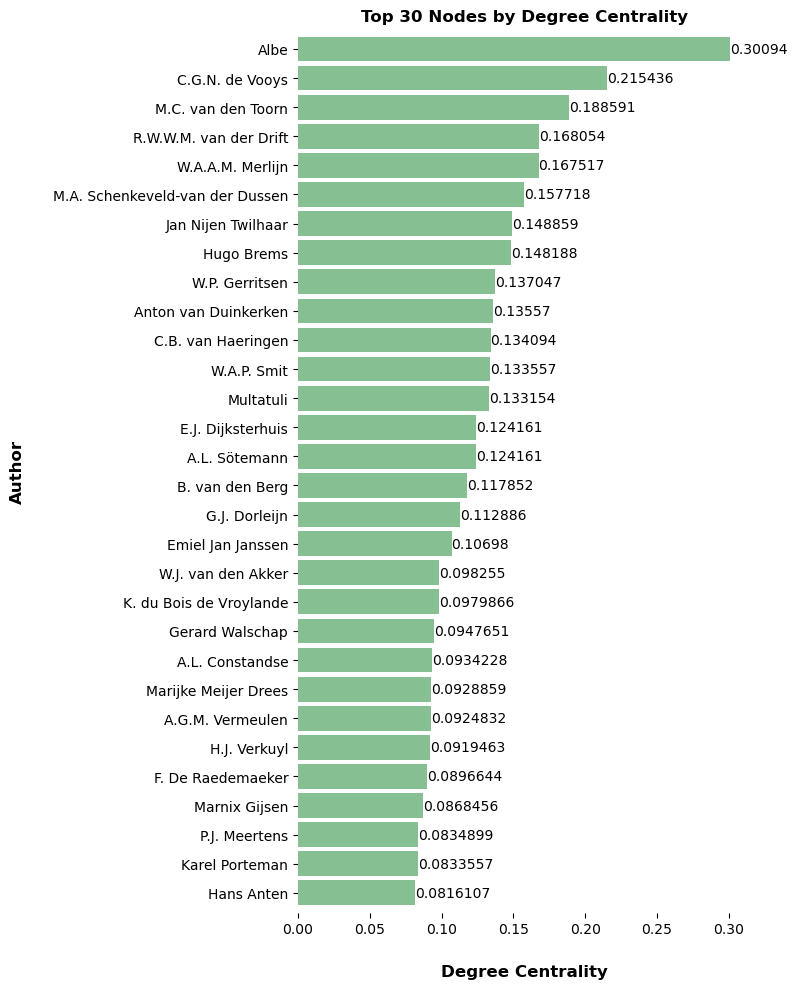

In [39]:
## Degree Centrality
top_degree_nodes = degree_df.sort_values('Degree', ascending=False).head(30)

import matplotlib.pyplot as plt

# Plot Top 30 Nodes by Degree Centrality
ax = top_degree_nodes.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and Title
ax.set_xlabel("Degree Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Degree Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.savefig('degree_centrality.png', dpi=300, bbox_inches='tight')

plt.show()

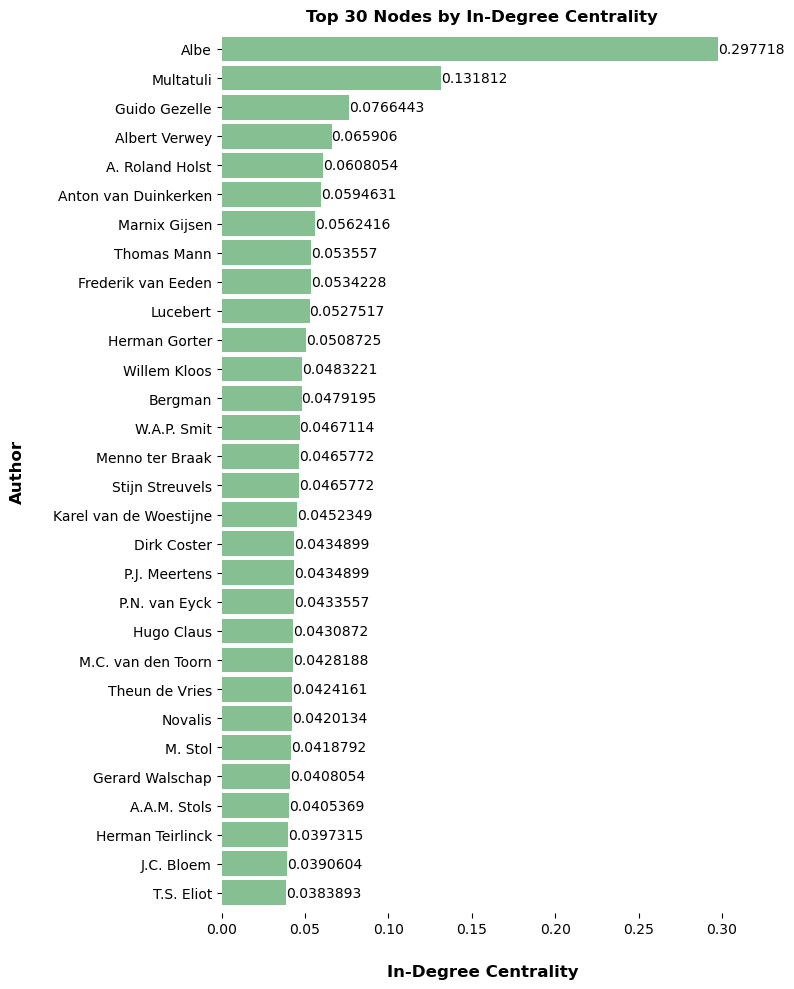

In [40]:
## In-Degree Centrality
top_in_degree_nodes = in_degree_df.sort_values('In-degree', ascending=False).head(30)

# Plot Top 30 Nodes by In-Degree Centrality
ax = top_in_degree_nodes.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and Title
ax.set_xlabel("In-Degree Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by In-Degree Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.savefig('in_degree_centrality.png', dpi=300, bbox_inches='tight')

plt.show()

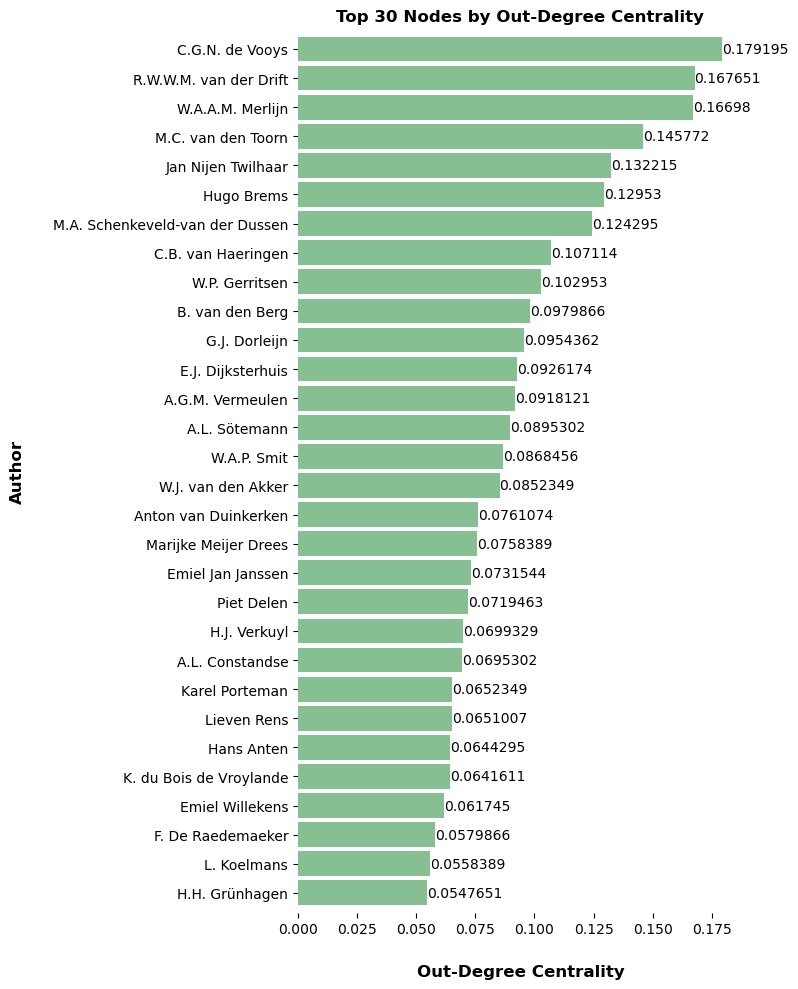

In [41]:
## Out-Degree Centrality
top_out_degree_nodes = out_degree_df.sort_values('Out-degree', ascending=False).head(30)

# Plot Top 30 Nodes by Out-Degree Centrality
ax = top_out_degree_nodes.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and Title
ax.set_xlabel("Out-Degree Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Out-Degree Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.savefig('out_degree_centrality.png', dpi=300, bbox_inches='tight')

plt.show()

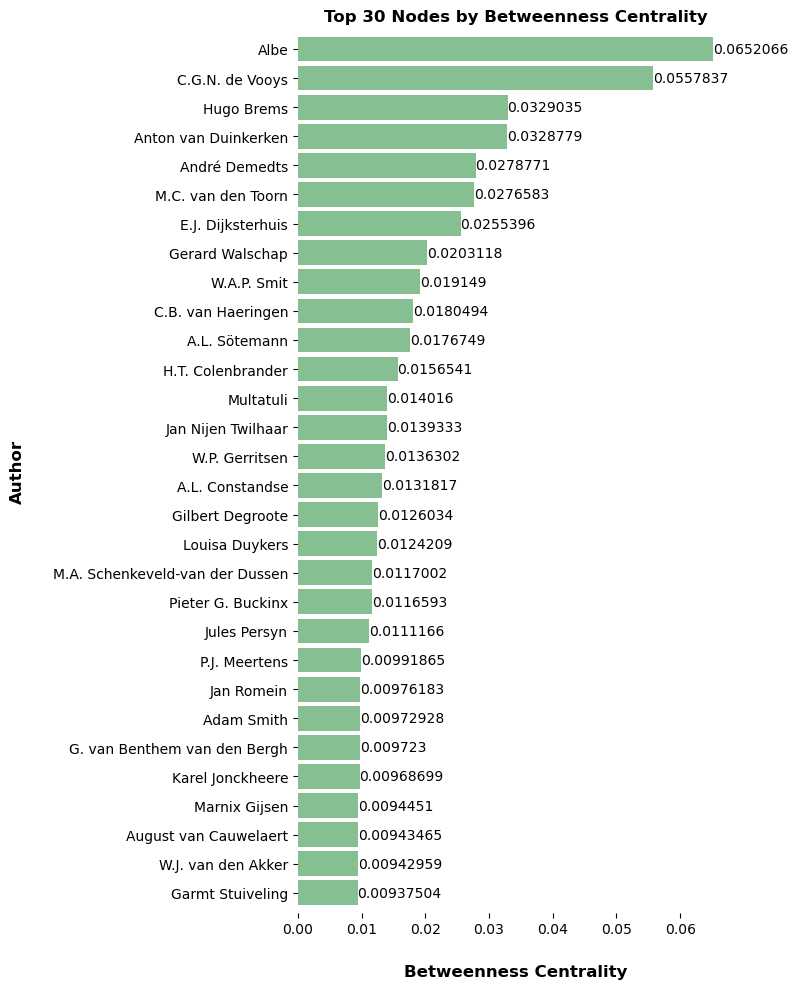

In [42]:
## Betweenness Centrality
top_betweenness_nodes = betweenness_df.sort_values('Betweenness', ascending=False).head(30)

# Plot Top 30 Nodes by Betweenness Centrality
ax = top_betweenness_nodes.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and Title
ax.set_xlabel("Betweenness Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Betweenness Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.savefig('betweenness_centrality.png', dpi=300, bbox_inches='tight')

plt.show()

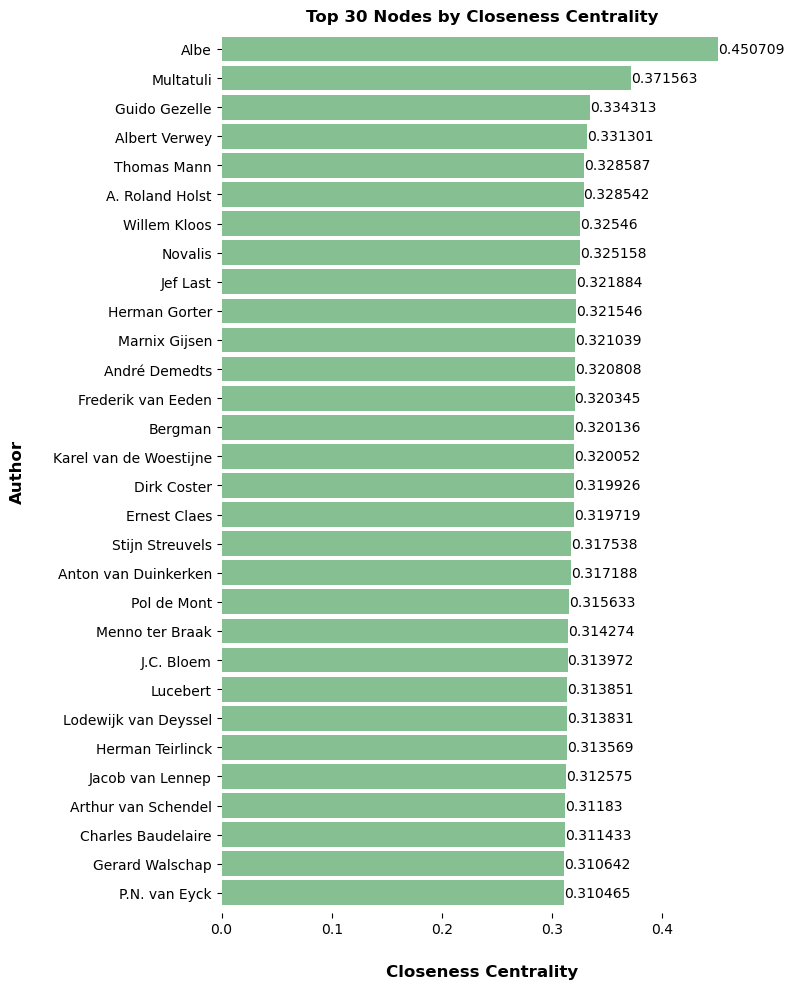

In [43]:
## Closeness Centrality
top_closeness_nodes = closeness_df.sort_values('Closeness', ascending=False).head(30)

# Plot Top 30 Nodes by Closeness Centrality
ax = top_closeness_nodes.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and Title
ax.set_xlabel("Closeness Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Closeness Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.savefig('closeness_centrality.png', dpi=300, bbox_inches='tight')

plt.show()

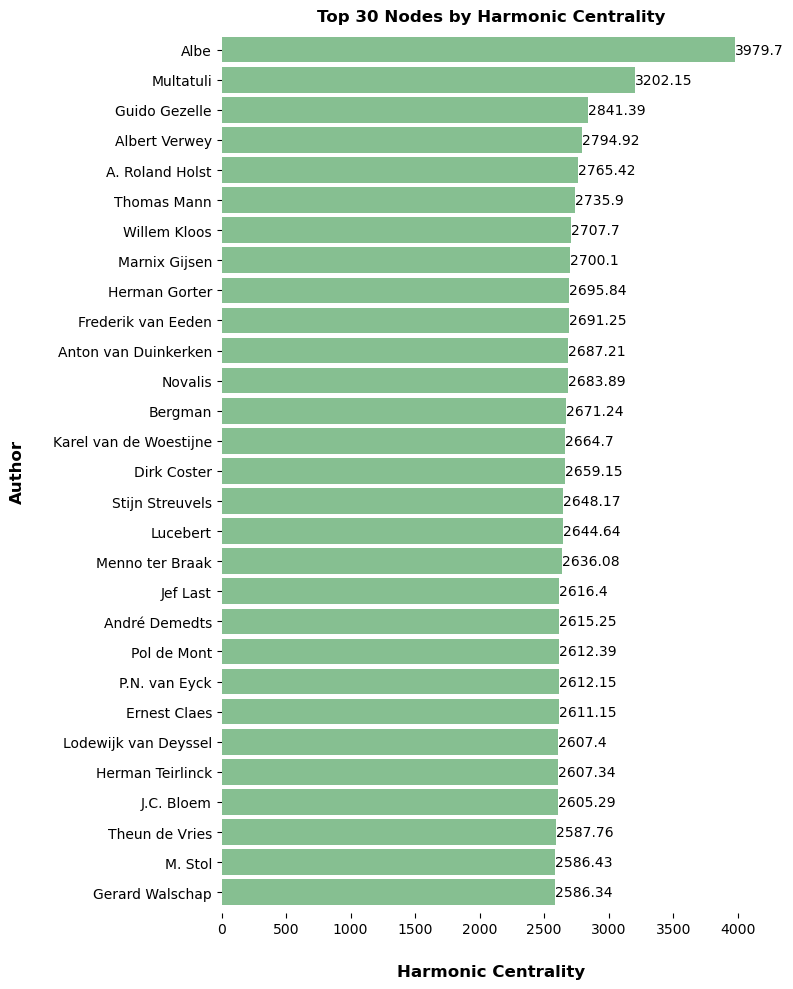

In [44]:
## Harmonic Centrality
x = harmonic_df.sort_values('Harmonic', ascending=False)[0:29]

# Plot top 30 nodes
ax = x.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and title
ax.set_xlabel("Harmonic Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Harmonic Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.savefig('harmonic_centrality.png', dpi=300, bbox_inches='tight')

plt.show()

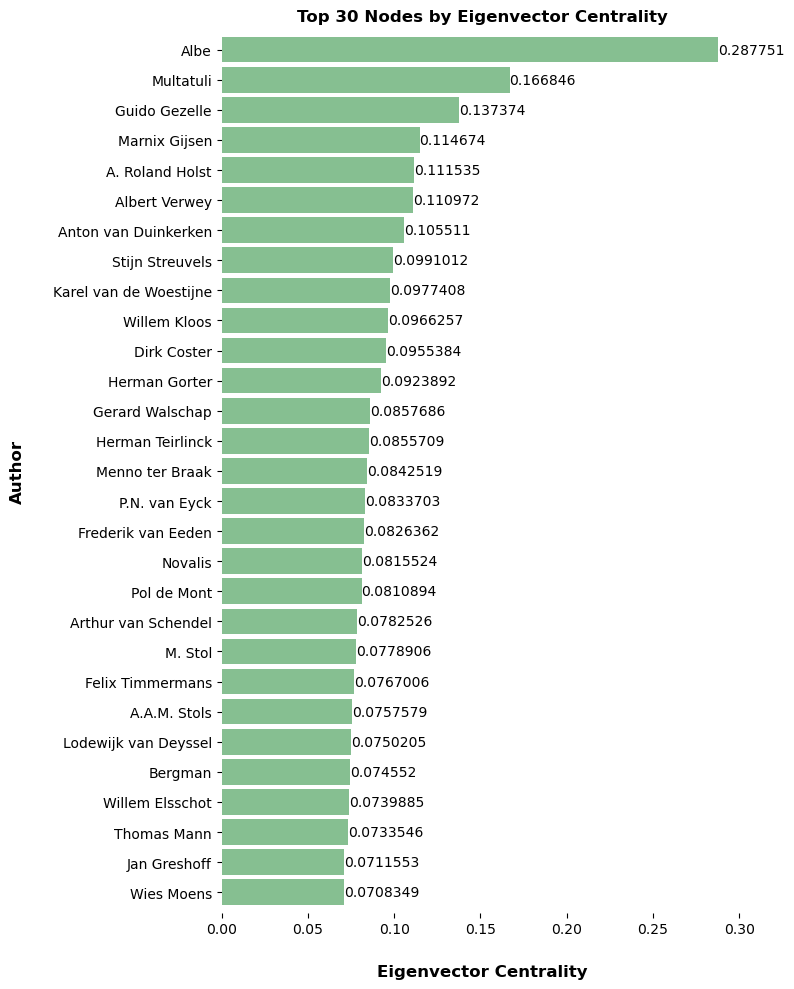

In [45]:
## Eigenvector Centrality
x = eigenvector_df.sort_values('Eigenvector', ascending=False)[0:29]

# Plot top 30 nodes
ax = x.plot(kind="barh", figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Labels and title
ax.set_xlabel("Eigenvector Centrality", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Author", labelpad=20, weight='bold', size=12)
ax.set_title("Top 30 Nodes by Eigenvector Centrality", size=12, weight='bold')

ax.invert_yaxis()  # Reverse the y-axis
ax.bar_label(ax.containers[0])  # Add labels to the bars
plt.tight_layout()  # Adjust layout
ax.legend().set_visible(False)

plt.savefig('eigenvector_centrality.png', dpi=300, bbox_inches='tight')

plt.show()

## Community sizes

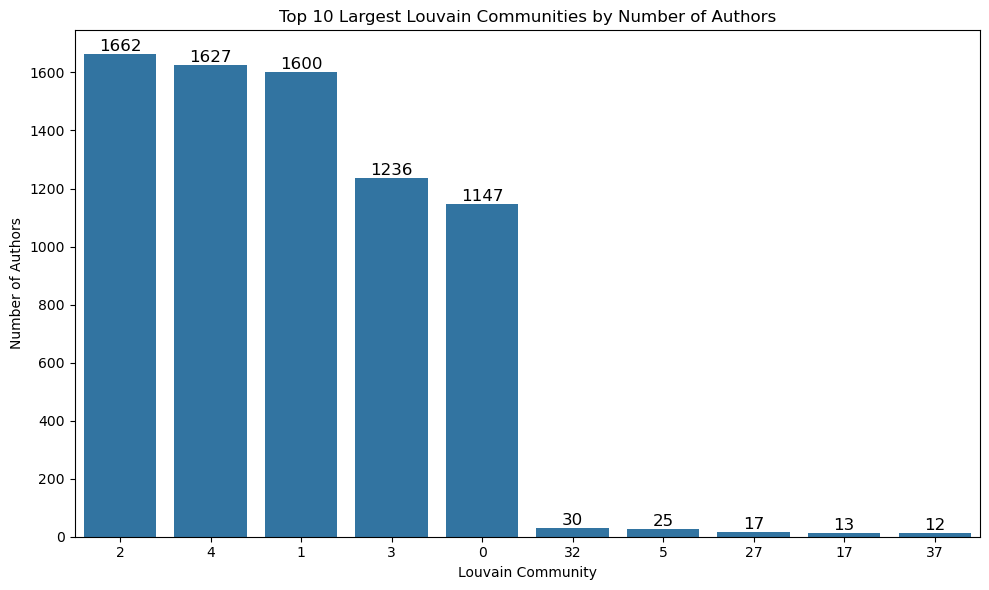

In [47]:
# Louvain
network_metadata_df['Community'] = network_metadata_df['Community'].astype(str)

community_counts = network_metadata_df['Community'].value_counts()
top_10_communities = community_counts.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_communities.index, y=top_10_communities.values, order=top_10_communities.index)

plt.xlabel('Louvain Community')
plt.ylabel('Number of Authors')
plt.title('Top 10 Largest Louvain Communities by Number of Authors')

for i, value in enumerate(top_10_communities.values):
    plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()

plt.savefig('community_size_louvain.png', dpi=300, bbox_inches='tight')

plt.show()

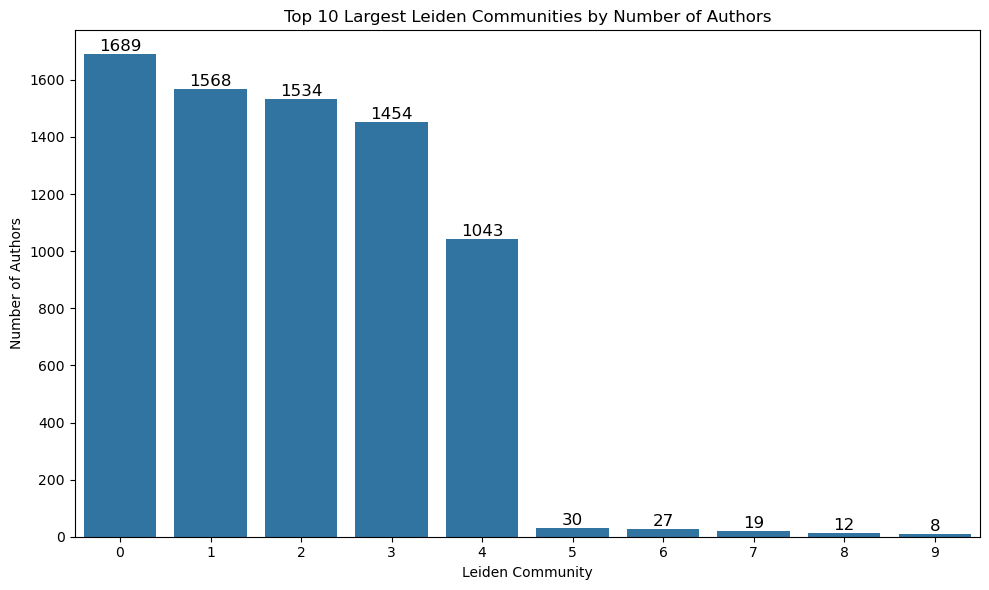

In [48]:
# Leiden
network_metadata_df['Partition'] = network_metadata_df['Partition'].astype(str)

community_counts = network_metadata_df['Partition'].value_counts()
top_10_communities = community_counts.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_communities.index, y=top_10_communities.values, order=top_10_communities.index)

plt.xlabel('Leiden Community')
plt.ylabel('Number of Authors')
plt.title('Top 10 Largest Leiden Communities by Number of Authors')

for i, value in enumerate(top_10_communities.values):
    plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()

plt.savefig('community_size_leiden.png', dpi=300, bbox_inches='tight')

plt.show()